# **NLP Over a SXSW Twitter Data Set**

## Package and Data Import

*Package Imports*

In [1]:
### Packages to Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.svm import SVC
from nltk.tokenize import RegexpTokenizer
from collections import Counter
from wordcloud import WordCloud
import warnings
nltk.download('wordnet')
nltk.download('vader_lexicon')

pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\moore\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\moore\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


*Importing CSV File*

In [2]:
### Import Data and Change Column Names

df = pd.read_csv("data/tweets.csv")
df.columns = ['text', 'device', 'emotion']

## Pre-Data Cleaning Column Addition

**Create column that counts the amount of mentions in a tweet**

In [3]:
### Creating a column that counts the amount of mentions in each tweet

df['mentions'] = df.text.str.count('@')

**Create a column that counts the amount of links in a tweet**

*We are also considering anything with '.com', 'http', 'bit.ly', '.co', and '{link}' as a link*

In [4]:
df['links'] = 0

url_like_strings = ['{link}', '.com', 'http', 'bit.ly', '.co']
for s in url_like_strings:
    df['links'] = df.links + list(map(lambda x: str(x).count(s), df['text']))

## Data Cleaning

**Dropping non-significant values and rows**

In [5]:
### Dropping 'I can't tell' and 'Other' rows

df = df[df['emotion'] != "I can't tell"]

### Dropping blank 'text' rows

df = df.dropna(subset=['text'])

**Creating functions that clean the text data**

In [6]:
### Creating a function that makes all text lowercase for further analysis

def lower_case(text):
    text = text.lower()
    return text

### Creating a function that removes the use of via in the context of via hashtag or via mention (removes 80% of vias)

def remove_via(text):
    
    if 'via @' in text or 'via #' in text:
        text = text.replace('via', '')
    return text
    
### Creating a function that removes errant html syntax from the tweet (e.g. &amp; and &quot;)

def remove_html(text):
    
    text = text.replace('&amp;', '')
    text = text.replace('&quot;', '')
    return text

### Creating a function that removes urls or instances of '{link}' from the tweet

def remove_url(text):
    
    url_like_strings = ['{link}', '.com', 'http', 'bit.ly', '.co']
    text = text.split()
    for s in url_like_strings:
        text = [word for word in text if s not in word]
    text = ' '.join(text)
    return text

### Creating a function that removes words that contain a @ and rt (retweet) 
### as mentions would not be important in determining the emotion of a tweet

def remove_at_and_rt(text):
    text = text.split()
    text = [word for word in text if '@' not in word]
    text = [word for word in text if word != 'rt']
    text = ' '.join(text)
    return text

### Creating a function that removes '#SXSW' of any case type from the text

def remove_sxsw(text):
    text = text.split()
    text = [word for word in text if '#sxsw' not in word]
    text = ' '.join(text)
    return text

### Creating a function that uses a regex tokenizer to remove punctuation but ignores contraction apostrophes

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+\'?\w+')
    text = tokenizer.tokenize(text)
    text = ' '.join(text)
    return text

### Creating a function that removes stopwords from a specified list of stopwords

custom_stop_words = ['in','of','at','a','the']

def remove_stopwords(text, stop_words_list = set(stopwords.words('english'))):
    text = text.split()
    text = [word for word in text if word not in stop_words_list]
    text = ' '.join(text)
    return text

### Creating a function that removes non-ASCII characters

def remove_characters(text):
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

### Creating a function that lemmatizes words

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

### Creating a function that combines all of the above functions

def clean_text(text):
    text = lower_case(text)
    text = remove_via(text)
    text = remove_html(text)
    text = remove_url(text)
    text = remove_at_and_rt(text)
    text = remove_sxsw(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_characters(text)
    text = lemmatize(text)
    return text

In [7]:
### Example of before and after cleaning

print(df.text[60])
print(clean_text(df['text'][60]))

&quot;via @mention : {link} Guy Kawasaki talks 'Enchanted' at SXSW - HE knows his stuff! #books #internet #Apple #sxsw  &quot;
guy kawasaki talk enchanted sxsw know stuff book internet apple


In [8]:
### Applying the clean_text function to the 'text' column and creating a santiy check csv

df_clean = df.copy()
df_clean['text'] = df_clean['text'].apply(clean_text)
df_clean.to_csv('data/cleaned_tweets.csv')

## Feature Engineering

**Creating 'device_type'**

In [9]:
### Deliniating between Google and Apple

google_tweets = ['Google', 'Other Google product or service', 'Andriod App', 'Andriod']
apple_tweets = ['Apple', 'Other Apple product or service', 'Apple App', 'iPhone', 'iPad', 'iPad or iPhone App']

### Creating a new column for google vs. apple vs. unknown

df['device_type'] = np.where(df['device'].isin(google_tweets), 'Google', 
                    np.where(df['device'].isin(apple_tweets), 'Apple', 
                             'Unknown'))

**Approximating 'Company' Values based off of 'text' and 'device_type'**

In [10]:
### Creating a new column for 'Google' and 'Apple' based on device type and key words in the 'text' column

google_key_words = ["Google", "Android", "Pixel", "Circles", "Droid", "Galaxy S", "Realtime", "Maps", "Google Maps", "Circle" ]

apple_key_words = ["Apple", "iPhone", "iPad", "Mac", "iMac", "iPod", "iTunes", "iWatch", "iMessage", "iCloud", "iBook", "iMac", 
                   "app_store", "app store", "ios", "ios4", "ios4.1", "ios4.2", "iphone app", "3g", "ios"]
                  
df['Google'] = np.where(df['device_type'] == 'Google', True, 
               np.where(df['text'].str.lower().str.contains('|'.join(google_key_words), case=False), True, 
               False))

df['Apple'] = np.where(df['device_type'] == 'Apple', True,
              np.where(df['text'].str.lower().str.contains('|'.join(apple_key_words), case=False), True,
              False))

### Create new column 'both' that is true if both Google and Apple are true

df['both'] = np.where((df['Google'] == True) & (df['Apple'] == True), True, False)

### Dropping rows where both Google and Apple are true and where Google and Apple are both false

df = df[df['both'] == False]
df = df[df['Google'] != df['Apple']]
df = df.drop(columns=['both'])


**Establishing a VADER Sentiment Score**

In [11]:
### Creating new columns in the dataframe which append 'pos', 'neg', and 'neu' using VADER sentiment analysis

sid = SentimentIntensityAnalyzer()
df['sentiment'] = df['text'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiment'], axis=1), df['sentiment'].apply(pd.Series)], axis=1)

**Creating 'emphasis' columns that score how many exclamation points, question marks, and capital letters are in the text, respectively**

In [12]:
### Creating an 'punc_emphasis' column that scores how many exclamation points and question marks are in the text

df['punc_emphasis'] = df['text'].apply(lambda x: sum([1 for char in x if char in ['!', '?']]))

### Creating a 'capt_emphasis' column that scores how many capitalized words are in the text

df['capt_emphasis'] = df['text'].apply(lambda x: sum([1 for word in x.split() if word.isupper()]))

## Exploring the Cleaned Data

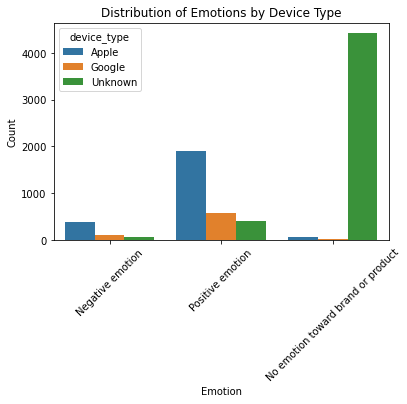

In [13]:
### Visualize the distribution of the target variable by device type

sns.countplot(x='emotion', hue='device_type', data=df)
plt.xlabel('Emotion')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.title('Distribution of Emotions by Device Type')
plt.show()


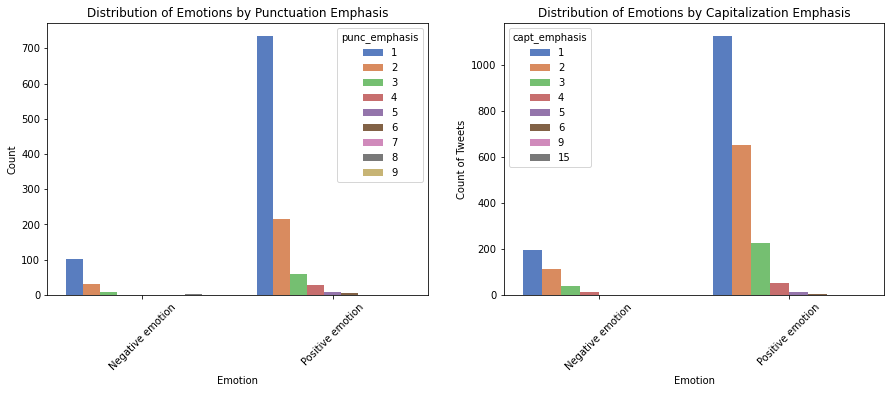

In [14]:
### Plot the distribution between the target variable and the emphasis columns, removing 0 values and 'no emotion' values

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x='emotion', hue='punc_emphasis', data=df[(df['punc_emphasis'] != 0) & (df['emotion'] != 'No emotion toward brand or product')], ax=ax[0], palette='muted')
sns.countplot(x='emotion', hue='capt_emphasis', data=df[(df['capt_emphasis'] != 0) & (df['emotion'] != 'No emotion toward brand or product')], ax=ax[1], palette='muted')
ax[0].set_xlabel('Emotion')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_ylabel('Count')
ax[0].set_title('Distribution of Emotions by Punctuation Emphasis')
ax[1].set_xlabel('Emotion')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].set_ylabel('Count of Tweets')
ax[1].set_title('Distribution of Emotions by Capitalization Emphasis')
plt.show()


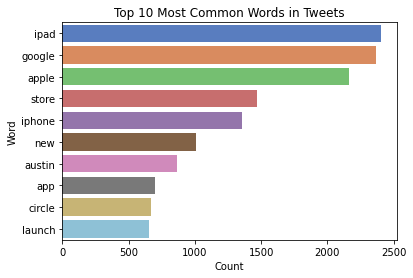

In [15]:
### Plotting the top 10 most common words in the 'text' column in an sns bar chart after applying the clean_text function

text = ' '.join(df['text'])
text = clean_text(text)
text = text.split()

freq = pd.Series(text).value_counts()[:10]
freq = freq.to_frame()
freq = freq.reset_index()
freq.columns = ['word', 'count']
freq = freq.sort_values(by='count', ascending=False)

sns.barplot(x='count', y='word', data=freq, palette='muted')
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Most Common Words in Tweets')
plt.show()

## Modeling

**First Simple Model - Count Vectorizer / Decision Tree / No Features**

In [16]:
### Breaking the data into a singular feature and the target variable

X1 = df['text']
y1 = df['emotion']

### Performing a train test split on the data

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=1337)

### TRAIN - Apply the clean_text function to the training data

X_train_1 = X_train_1.apply(clean_text)

### TRAIN - Tokenize the training data with a simple split of words, and then flattening to prepare for vectorization

X_train_1 = X_train_1.apply(lambda x: x.split())
X_train_1 = X_train_1.map(' '.join)

### TRAIN - Vectorize the training data using CountVectorizer

cv = CountVectorizer()
X_train_1 = cv.fit_transform(X_train_1)

### TRAIN - Fit the training data to a Decision Tree Classifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train_1, y_train_1)

### VALIDATION - Perform a cross validation on the decision tree classifier

scores = cross_val_score(dtc, X_train_1, y_train_1, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean())

Cross Validation Scores:  [0.66168371 0.63650669 0.63729347 0.63650669 0.63937008]
Mean Cross Validation Score:  0.6422721274710843


**Second Model - Count Vectorizer / Naive Bayes Model / Added Sentiment and Emphasis Score**

In [17]:
### Splitting the features into features and the target, including the 'text', sentiment columns, and emphasis columns as features

X2 = df[['text', 'punc_emphasis', 'capt_emphasis', 'links', 'mentions']]
y2 = df['emotion']

### Performing a train test split on the data

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.2, random_state=1337)

### TRAIN - Applying the clean_text function to the training data

X_train_2['text'] = X_train_2['text'].apply(clean_text)

### TRAIN - Tokenizing the training data with a simple split of words, and then flattening to prepare for vectorization

X_train_2['text'] = X_train_2['text'].apply(lambda x: x.split())
X_train_2['text'] = X_train_2['text'].map(' '.join)

### TRAIN - Vectorizing the training data using a CountVectorizer

cv = CountVectorizer()
X_train_2 = cv.fit_transform(X_train_2['text'])

### TRAIN - Fit the training data to a Naive Bayes Classifier

nb = MultinomialNB()
nb.fit(X_train_2, y_train_2)

### VALIDATION - Perform a cross validation on the Naive Bayes Classifier

scores = cross_val_score(nb, X_train_2, y_train_2, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean())

Cross Validation Scores:  [0.63335956 0.64516129 0.64201416 0.6404406  0.63858268]
Mean Cross Validation Score:  0.6399116573842903


<ipython-input-17-15f9e7ab2346>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['text'] = X_train_2['text'].apply(clean_text)
<ipython-input-17-15f9e7ab2346>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['text'] = X_train_2['text'].apply(lambda x: x.split())
<ipython-input-17-15f9e7ab2346>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

**Third Model - TDIF Vectorizer / Random Forest / Added sentiment and Emphasis Scores**

In [18]:
### Splitting the features into features and the target, including the 'text', sentiment columns, and emphasis columns as features

X2 = df[['text', 'punc_emphasis', 'capt_emphasis', 'links', 'mentions']]
y2 = df['emotion']

### Performing a train test split on the data

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X2, y2, test_size=0.2, random_state=1337)

### TRAIN - Applying the clean_text function to the training data

X_train_3['text'] = X_train_3['text'].apply(clean_text)

### TRAIN - Tokenizing the training data with a simple split of words, and then flattening to prepare for vectorization

X_train_3['text'] = X_train_3['text'].apply(lambda x: x.split())
X_train_3['text'] = X_train_3['text'].map(' '.join)

### TRAIN - Vectorizing the training data using a TD-IDF Vectorizer

tfidf = TfidfVectorizer()
X_train_3 = tfidf.fit_transform(X_train_3['text'])

### TRAIN - Fit the training data to a Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(X_train_3, y_train_3)

### VALIDATION - Perform a cross validation on the Random Forest Classifier

scores = cross_val_score(rfc, X_train_3, y_train_3, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean())



<ipython-input-18-04ff80b9eba2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3['text'] = X_train_3['text'].apply(clean_text)
<ipython-input-18-04ff80b9eba2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3['text'] = X_train_3['text'].apply(lambda x: x.split())
<ipython-input-18-04ff80b9eba2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Cross Validation Scores:  [0.66797797 0.66640441 0.66797797 0.65381589 0.66456693]
Mean Cross Validation Score:  0.664148633663121


## Initial Tuning of Hyper Parameters via Grid Search

DTC Results = {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 5}
NBC Results = {'alpha': 2}
RFC Results = {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}

In [19]:
### Performing a grid search on the Decision Tree Classifier

param_grid = {'max_depth': [5, 10, 15, 20, 25],
                'min_samples_split': [2, 3, 5, 10],
                'min_samples_leaf': [1, 4, 8, 10],
                'max_features': ['auto', 'sqrt', 'log2']}
grid = GridSearchCV(dtc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_1, y_train_1)
print('Best Parameters: ', grid.best_params_)


### Performing a grid search on the Naive Bayes Classifier

param_grid = {'alpha': [0.1, 0.5, 1, 2, 5, 20, 50]}
grid = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_2, y_train_2)
print('Best Parameters: ', grid.best_params_)


Best Parameters:  {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3}
Best Parameters:  {'alpha': 2}


## Applying Initial Hyper Parameter Tuning to Models and Evaluating Results on Test Set

**Applying Hyperparameters**

In [20]:
### Applying the hyperparameters from the grid search to the Decision Tree Classifier

dtc = DecisionTreeClassifier(max_depth = 25, max_features = 'sqrt', min_samples_leaf = 4, min_samples_split = 10)
dtc.fit(X_train_1, y_train_1)

### Applying the hyperparameters from the grid search to the Naive Bayes Classifier

nb = MultinomialNB(alpha=2)
nb.fit(X_train_2, y_train_2)

### Applying the hyperparameters from the grid search to the Random Forest Classifier

rfc = RandomForestClassifier(max_depth = 15, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 2, n_estimators = 10)
rfc.fit(X_train_3, y_train_3)

RandomForestClassifier(max_depth=15, max_features='sqrt', n_estimators=10)

**Preprocessing Test Data on each Model**

In [21]:
### Decision Tree Test Set Preprocessing

X_test_1 = X_test_1.apply(clean_text)
X_test_1 = X_test_1.apply(lambda x: x.split())
X_test_1 = X_test_1.map(' '.join)
X_test_1 = cv.transform(X_test_1)

### Naive Bayes Test Set Preprocessing

X_test_2['text'] = X_test_2['text'].apply(clean_text)
X_test_2['text'] = X_test_2['text'].apply(lambda x: x.split())
X_test_2['text'] = X_test_2['text'].map(' '.join)
X_test_2 = cv.transform(X_test_2['text'])

### Random Forest Test Set Preprocessing

X_test_3['text'] = X_test_3['text'].apply(clean_text)
X_test_3['text'] = X_test_3['text'].apply(lambda x: x.split())
X_test_3['text'] = X_test_3['text'].map(' '.join)
X_test_3 = tfidf.transform(X_test_3['text'])

<ipython-input-21-a664f117a575>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_3['text'] = X_test_3['text'].apply(clean_text)
<ipython-input-21-a664f117a575>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_3['text'] = X_test_3['text'].apply(lambda x: x.split())
<ipython-input-21-a664f117a575>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

**Running Models on Test Data and Evaluating Results**

In [22]:
### Decision Tree Test Set Predictions

dtc_pred = dtc.predict(X_test_1)

### Naive Bayes Test Set Predictions

nb_pred = nb.predict(X_test_2)

### Random Forest Test Set Predictions

rfc_pred = rfc.predict(X_test_3)

In [23]:
### Decision Tree Test Set Evaluation

print('Decision Tree Accuracy: ', accuracy_score(y_test_1, dtc_pred))
print('Decision Tree F1 Score: ', f1_score(y_test_1, dtc_pred, average='weighted'))
print('Decision Tree Precision Score: ', precision_score(y_test_1, dtc_pred, average='weighted'))
print('Decision Tree Recall Score: ', recall_score(y_test_1, dtc_pred, average='weighted'))

### Naive Bayes Test Set Evaluation

print('Naive Bayes Accuracy: ', accuracy_score(y_test_2, nb_pred))
print('Naive Bayes F1 Score: ', f1_score(y_test_2, nb_pred, average='weighted'))
print('Naive Bayes Precision Score: ', precision_score(y_test_2, nb_pred, average='weighted'))
print('Naive Bayes Recall Score: ', recall_score(y_test_2, nb_pred, average='weighted'))

### Random Forest Test Set Evaluation

print('Random Forest Accuracy: ', accuracy_score(y_test_3, rfc_pred))
print('Random Forest F1 Score: ', f1_score(y_test_3, rfc_pred, average='weighted'))
print('Random Forest Precision Score: ', precision_score(y_test_3, rfc_pred, average='weighted'))
print('Random Forest Recall Score: ', recall_score(y_test_3, rfc_pred, average='weighted'))

Decision Tree Accuracy:  0.5953429830081812
Decision Tree F1 Score:  0.5298007533620285
Decision Tree Precision Score:  0.5861760980361294
Decision Tree Recall Score:  0.5953429830081812
Naive Bayes Accuracy:  0.644430459408433
Naive Bayes F1 Score:  0.6209944648665453
Naive Bayes Precision Score:  0.6511829653302442
Naive Bayes Recall Score:  0.644430459408433
Random Forest Accuracy:  0.5852737570799245
Random Forest F1 Score:  0.4672253237597553
Random Forest Precision Score:  0.6486554975202891
Random Forest Recall Score:  0.5852737570799245


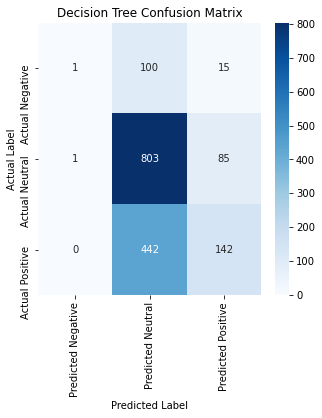

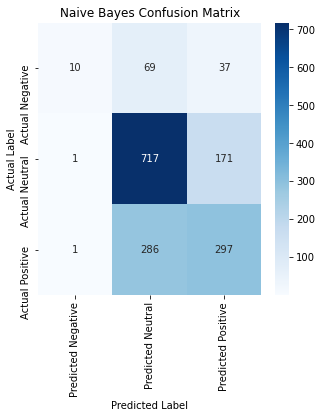

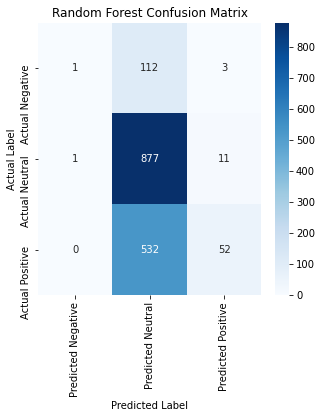

In [24]:
### Decision Tree Confusion Matrix

cm = confusion_matrix(y_test_1, dtc_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Naive Bayes Confusion Matrix

cm = confusion_matrix(y_test_2, nb_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

### Random Forest Confusion Matrix

cm = confusion_matrix(y_test_3, rfc_pred)
cm_df = pd.DataFrame(cm, index=['Actual Negative', 'Actual Neutral', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Neutral', 'Predicted Positive'])
plt.figure(figsize=(5, 5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

## Validation of Models: Comparison of Results and F1 Scores

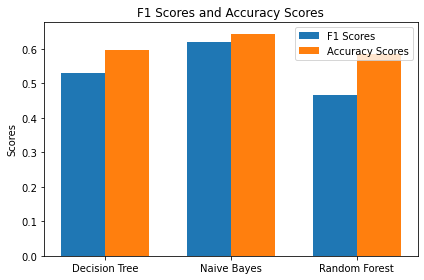

In [25]:
### Visualizing the F1 scores and accuracy scores in a bar chart

f1_scores = [f1_score(y_test_1, dtc_pred, average='weighted'), f1_score(y_test_2, nb_pred, average='weighted'), f1_score(y_test_3, rfc_pred, average='weighted')]
accuracy_scores = [accuracy_score(y_test_1, dtc_pred), accuracy_score(y_test_2, nb_pred), accuracy_score(y_test_3, rfc_pred)]
x = np.arange(len(f1_scores))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, f1_scores, width, label='F1 Scores')
rects2 = ax.bar(x + width/2, accuracy_scores, width, label='Accuracy Scores')
ax.set_ylabel('Scores')
ax.set_title('F1 Scores and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(['Decision Tree', 'Naive Bayes', 'Random Forest'])
ax.legend()
fig.tight_layout()
plt.show()


## Further Tuning: Creating a Function which runs all models and returns accuracy and F1 scores

In [26]:
### Creating a function that performs SMOTE and then fits X_train, y_train, X_test, and y_test to the Decision Tree Classifier, Naive Bayes Classifier, and Random Forest Classifier and returns the F1 scores and accuracy scores

def smote_fit_evaluate(X_train, y_train, X_test, y_test):
    sm = SMOTE(random_state=1337, sampling_strategy='minority')
    X_train, y_train = sm.fit_resample(X_train, y_train)
    dtc.fit(X_train, y_train)
    dtc_pred = dtc.predict(X_test)
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    f1_scores = [f1_score(y_test, dtc_pred, average='weighted'), f1_score(y_test, nb_pred, average='weighted'), f1_score(y_test, rfc_pred, average='weighted')]
    accuracy_scores = [accuracy_score(y_test, dtc_pred), accuracy_score(y_test, nb_pred), accuracy_score(y_test, rfc_pred)]
    return f1_scores, accuracy_scores

def fit_evaluate(X_train, y_train, X_test, y_test):
    dtc.fit(X_train, y_train)
    dtc_pred = dtc.predict(X_test)
    nb.fit(X_train, y_train)
    nb_pred = nb.predict(X_test)
    rfc.fit(X_train, y_train)
    rfc_pred = rfc.predict(X_test)
    f1_scores = [f1_score(y_test, dtc_pred, average='weighted'), f1_score(y_test, nb_pred, average='weighted'), f1_score(y_test, rfc_pred, average='weighted')]
    accuracy_scores = [accuracy_score(y_test, dtc_pred), accuracy_score(y_test, nb_pred), accuracy_score(y_test, rfc_pred)]
    return f1_scores, accuracy_scores

test = smote_fit_evaluate(X_train_1, y_train_1, X_test_1, y_test_1)
print(test)

test2 = fit_evaluate(X_train_1, y_train_1, X_test_1, y_test_1)
print(test2)



([0.39773667860994044, 0.6168765852761962, 0.41523895764584046], [0.35871617369414727, 0.6198867212083071, 0.4115796098174953])
([0.4873559539475876, 0.6209944648665453, 0.4606899774573662], [0.5890497168030208, 0.644430459408433, 0.5846444304594084])


## Deployment of the Model: Making Word Clouds and Visualizations of Predicted Sentiment

In [27]:
### Function that takes in a list of tweets, performs the preprocessing steps by applying clean_text, and creates a new dataframe that contains the tweet and the predicted sentiment

def predict_sentiment(tweets):
    tweets = [clean_text(tweet) for tweet in tweets]
    tweets_vectorized = cv.transform(tweets)
    predictions = nb.predict(tweets_vectorized)
    df = pd.DataFrame({'tweet': tweets, 'sentiment': predictions})
    return df

In [28]:
### Testing the predict_sentiment function with a series of dummy tweets

test = ['I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE PRODUCT', 'I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE HATE ANGRY HATE HATE HATE', 'I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE HATE ANGRY HATE HATE HATE', 'I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE HATE ANGRY HATE HATE HATE', 'I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE HATE ANGRY HATE HATE HATE', 'I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE HATE ANGRY HATE HATE HATE', 'I love this product!', 'I hate this product!', 'I am neutral about this product.', 'I am not sure about this product.', 'HATE HATE HATE ANGRY HATE HATE HATE']

test_df = predict_sentiment(test)
test_df.head()

,tweet,sentiment
0,love product,Positive emotion
1,hate product,No emotion toward brand or product
2,neutral product,No emotion toward brand or product
3,sure product,No emotion toward brand or product
4,hate hate product,Negative emotion


In [31]:
### Creating a function that takes in a dataframe that contains the tweet and the predicted sentiment, and returns three word clouds delinated by the sentiment

def create_word_clouds(df):
    df_negative = df[df['sentiment'] == 'Negative emotion']
    df_neutral = df[df['sentiment'] == 'No emotion toward brand or product']
    df_positive = df[df['sentiment'] == 'Positive emotion']
    negative_text = ' '.join(df_negative['tweet'])
    neutral_text = ' '.join(df_neutral['tweet'])
    positive_text = ' '.join(df_positive['tweet'])
    negative_wordcloud = WordCloud(width=600, height=400, collocations=False).generate(negative_text)
    neutral_wordcloud = WordCloud(width=600, height=400, collocations=False).generate(neutral_text)
    positive_wordcloud = WordCloud(width=600, height=400, collocations=False).generate(positive_text)
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(negative_wordcloud, interpolation='bilinear')
    ax[0].set_title('Negative Sentiment')
    ax[0].axis('off')
    ax[1].imshow(neutral_wordcloud, interpolation='bilinear')
    ax[1].set_title('Neutral Sentiment')
    ax[1].axis('off')
    ax[2].imshow(positive_wordcloud, interpolation='bilinear')
    ax[2].set_title('Positive Sentiment')
    ax[2].axis('off')
    plt.show()

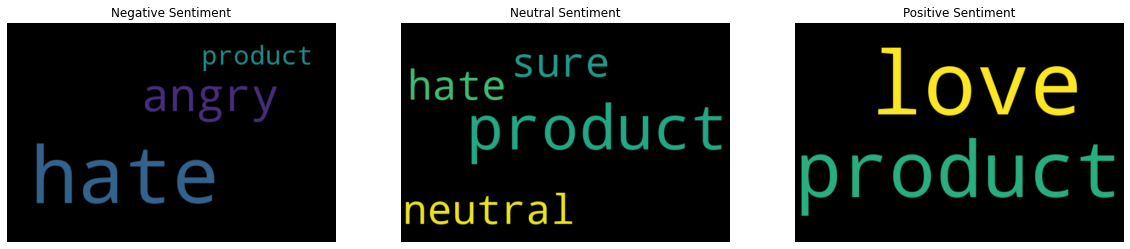

In [32]:
### Testing the word_cloud function with the test_df dataframe

create_word_clouds(test_df)